In [2]:
'''
This file should be helpful to gain all the parameters of a tuneup, 
save them to this notebook for recall, 
and copy it into wherever you're storing the data for reference
'''
from instrument_drivers.base_drivers.Keysight_N5183B import Keysight_N5183B
from instrument_drivers.base_drivers.Yokogawa_GS200 import YOKO
from instrument_drivers.base_drivers.SignalCore_sc5511a import SignalCore_SC5511A
from instrument_drivers.base_drivers.MiniCircuits_Switch import MiniCircuits_Switch
from instrument_drivers.base_drivers.switch_control import SWT as SWTCTRL
from instrument_drivers.base_drivers.Keysight_MXA_N9020A import Keysight_MXA_N9020A
from instrument_drivers.driver_wrappers.Hat_MXA_N9020A import Hat_MXA_N9020A
# from hatdrivers.Tektronix_AWG5014C import Tektronix_AWG5014C
from instrument_drivers import DLL
# from hatdrivers.YROKO import YROKO_Client

#customized drivers
from instrument_drivers.driver_wrappers.Hat_P9374A import Hat_P9374A
from instrument_drivers.driver_wrappers.Hat_ENA5071C  import Hat_ENA5071C
#Metainstruments and tools ... 
from instrument_drivers.meta_instruments import Modes

from instrument_drivers.driver_wrappers.Hat_AWG5014C import Hat_AWG5014C
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014

%matplotlib nbagg
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['figure.subplot.bottom'] = 0.15


C:\Users\Hatlab_3\anaconda3\envs\qcodes\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


In [3]:
#initialize the instruments: 
awg = Tektronix_AWG5014('AWG2', 'TCPIP0::169.254.116.102::inst0::INSTR', timeout=40)
CXA = Hat_MXA_N9020A("CXA", address = 'TCPIP0::169.254.110.116::INSTR')
#%%SignalCores
dll_path = r'C:\Users\Hatlab_3\Desktop\RK_Scripts\New_Drivers\HatDrivers\DLL\sc5511a.dll'
# SC5 = SignalCore_SC5511A('SigCore5', serial_number = '10001851', debug = True)
# SC9 = SignalCore_SC5511A('SigCore9', serial_number = '1000190E', debug = True)
SC4 = SignalCore_SC5511A('SigCore4', serial_number = '10001851', debug = True)
LO = SC4

Connected to: TEKTRONIX AWG5014C (serial:B050109, firmware:SCPI:99.0 FW:4.6.0.7) in 0.16s
Connected to: Keysight Technologies N9000B (serial:MY60250463, firmware:A.28.05) in 0.39s
<CDLL 'c:\users\hatlab_3\documents\github\instrument_drivers\instrument_drivers\DLL\sc5511a.dll', handle 7ff9e9140000 at 0x1bafd9075b0>
10001851 c_void_p(1902574624016)
check status 1


In [4]:
#now check the status of the signalcores and turn them on at the right frequencies:
#for this amp at 0 bias the resonant frequency is at 6229339646.96
LO_freq = 7.45e9
mod_freq = 50e6
# SC5.frequency(LO_freq-mod_freq)
LO.frequency(LO_freq)
# SC5.power(16)
LO.power(9)
# SC5.output_status(1)
LO.output_status(1)
# SC5.output_status(0)
# SC9.output_status(0)

Count complete


<IPython.core.display.Javascript object>


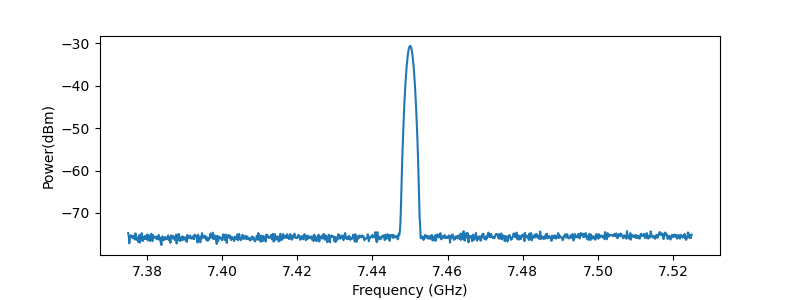

Max of trace: -30.59274412
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0


In [8]:
#now we can tune the mixer leakage. Let's check out what's happening right now at the LO frequency
CXA.fcenter(LO_freq)
CXA.fspan(150e6)
CXA.plot_trace(avgnum = 100)
CXA.print_important_info()

<IPython.core.display.Javascript object>


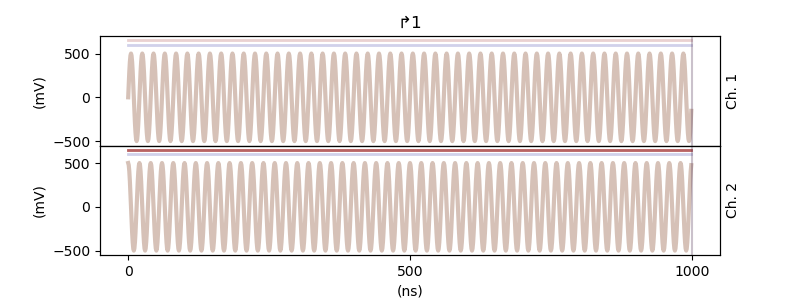

Count complete


<IPython.core.display.Javascript object>


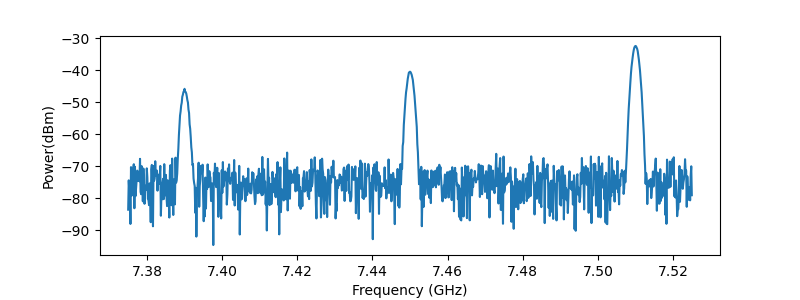

Max of trace: -32.41959763
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0


-32.41959763

In [9]:
#so as you can see, we have bad LO leakage. 
#To fix this and prep the next stage, we are first going to load a test pulse into the AWG
from broadbean.broadbean import PulseAtoms as PA

def flat(ampl, SR, npts):
    return ampl*np.ones(npts)

tuneUp = bb.BluePrint()
tuneUp.insertSegment(0, PA.sine, (50e6, 0.5, 0, 0), name='sine', dur=1e-6)
tuneUp.setSR(1e9)

tuneUpMarker = bb.BluePrint()
tuneUpMarker.insertSegment(0, PA.sine, (50e6, 0.5, 0, np.pi/2), name='cosine', dur=1e-6)
tuneUpMarker.marker1 = [(0,1e-5)]
tuneUpMarker.setSR(1e9)
# plotter(tuneUpMarker)


tuneUpEl = bb.Element()
tuneUpEl.addBluePrint(1, tuneUp)
tuneUpEl.addBluePrint(2, tuneUpMarker)

tuneUpSeq = bb.Sequence()
tuneUpSeq.addElement(1, tuneUpEl)
tuneUpSeq.setSR(1e9)
tuneUpSeq.setChannelAmplitude(1, 3)  # Call signature: channel, amplitude (peak-to-peak)
tuneUpSeq.setChannelAmplitude(2, 3) 
tuneUpSeq.setSequencingTriggerWait(1, 0)
tuneUpSeq.setSequencingNumberOfRepetitions(1, 1)
tuneUpSeq.setSequencingEventJumpTarget(1, 0)
tuneUpSeq.setSequencingGoto(1, 1) #infinite loop
tuneUpSeq.setChannelOffset(1, 0)
tuneUpSeq.setChannelOffset(2, 0)

tuneUpSeq.checkConsistency()
plotter(tuneUpSeq)

#upload to awg and reset offsets
package = tuneUpSeq.outputForAWGFile()
chan1_awg_input = package[0]
chan2_awg_input = package[1]
package.channels
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_offset(0), awg.ch2_offset(0), awg.ch3_offset(0), awg.ch4_offset(0)
awg.ch1_amp(2)
awg.ch2_amp(2)

awg.run()
awg.ch1_state(1)
awg.ch2_state(1)
CXA.plot_trace()


In [10]:
#run this when you've manually tuned the offsets to suppress LO leakage
good_offsets = (awg.ch1_offset(), awg.ch2_offset(), awg.ch3_offset(), awg.ch4_offset())
# good_skew = (awg.ch1_skew(), awg.ch2_skew(), awg.ch3_skew(), awg.ch4_skew())
good_amps = (awg.ch1_amp(), awg.ch2_amp(), awg.ch3_amp(), awg.ch4_amp())
print(good_offsets)
print(good_amps)

(-0.113, -0.078, 0.0, 0.0)
(2.0, 2.0, 1.0, 1.0)


Skew 1, -1.11ns, skew 2, 0.0ns
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0
Count complete


<IPython.core.display.Javascript object>


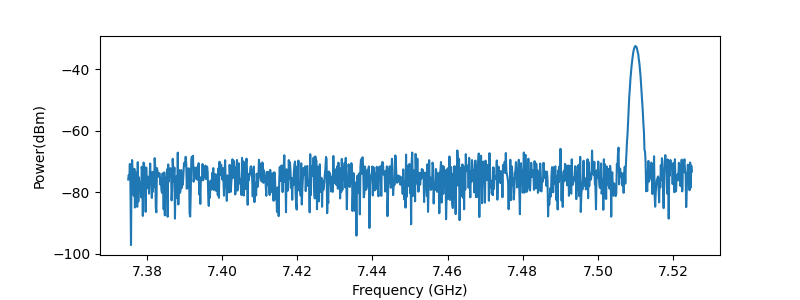

Max of trace: -32.37286377
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0


-32.37286377

In [11]:
print("Skew 1, -1.11ns, skew 2, 0.0ns")
awg.ch1_offset(good_offsets[0])
awg.ch2_offset(good_offsets[1])
awg.ch1_amp(good_amps[0])
awg.ch2_amp(good_amps[1])
awg.ch1_state(1)
awg.ch2_state(1)
awg.run()
import time
time.sleep(0.5)
CXA.print_important_info()
CXA.plot_trace()

Count complete


<IPython.core.display.Javascript object>


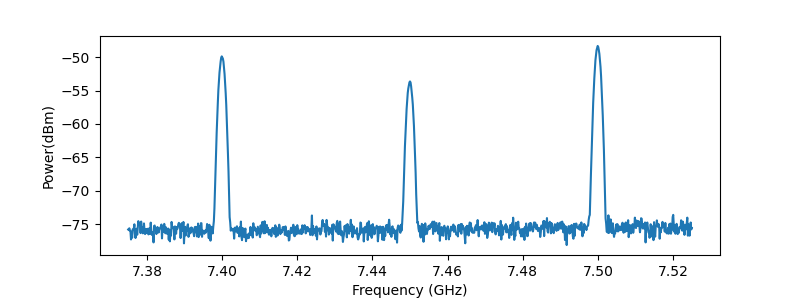

Max of trace: -48.33403328
Span: 150000000.0
RBW: 1500000.0
VBW: 1500000.0


In [66]:
'''
not much of a peak anymore! DC leakage is good
now we need to tune out the lower sideband. 
To do this , we can change the phase of one of the two channels until the lower band goes away. 
first, just adjust the amplitude of the second channel to get the lower sideband out of the way.
Then, start changing phase digitally
'''
import time
#turning on channel 1
phase_shift = 0 #degrees
ch1amp = 2
tuneUpSeq.element(1).changeArg(1, 'sine', 'phase', phase_shift*2*np.pi/360)
package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_amp(ch1amp)
awg.ch1_state(1)
awg.ch2_state(1)
awg.run()
time.sleep(0.5)
ch1_pow = CXA.plot_trace(avgnum = 50)


In [126]:
#try changing LO phase
SC5.phase()

AttributeError: 'SignalCore_SC5511A' object and its delegates have no attribute 'phase'

In [88]:
#that was channel 1, so I, now for Q: 
#turning on channel 2
tuneUpSeq.element(1).changeArg(1, 'plateau', 'ampl', 0)
tuneUpSeq.element(1).changeArg(2, 'plateau', 'ampl', 1/np.sqrt(2))
plotter(tuneUpSeq)
package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_state(1)
awg.ch2_state(1)
time.sleep(0.5)
ch2_pow = CXA.plot_trace(avgnum = 50)

ValueError: No segment of that name in blueprint. Contains segments: ['sine']

In [ ]:
#there we go, so we have our amplitude imbalance
def amplitude_correction(ch1_amp, ch2_amp, perfect_channel = 1): 
    '''
    this function will do the log linear conversion from dbm 
    to voltage and do the division to determine the amplitude correction factor
    '''
    perfect_channel -=1 #change to array notation
    channels = np.array([ch1_amp, ch2_amp])
    linear_power = np.power(np.array([10,10]), channels/20)*1e-3 #dB(milliwatt)
    voltage = np.sqrt(linear_power)
    correction_factor = voltage[perfect_channel]/voltage[(perfect_channel+1) % 2]
    return correction_factor

ch2_correction = amplitude_correction(ch1_pow,ch2_pow, perfect_channel = 1)    
print(f"Ch2_correction: {ch2_correction}")

In [ ]:
'''now that we know the amplitude correction factor, 
we can turn both channels on WITH correction and 
measure the change in amplitude to get the phase correction.
'''
#turning on both channels
tuneUpSeq.element(1).changeArg(1, 'plateau', 'ampl', 1/np.sqrt(2))
tuneUpSeq.element(1).changeArg(2, 'plateau', 'ampl', 1*ch2_correction/np.sqrt(2))

package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_state(1)
awg.ch2_state(1)
time.sleep(1)
combined_pow = CXA.plot_trace(avgnum = 500)

In [ ]:
#when you're done, run this cell to print a summary: 
print(f"Ch1 by itself: {ch1_pow}")
print(f"Combined Power: {combined_pow}")
print(f"Difference In Power: {combined_pow-ch1_pow}")
linear_ratio = np.sqrt(np.power(10, (combined_pow-ch1_pow)/10))
print(f"Difference In Power (linear voltage ratio): {linear_ratio}")

In [ ]:
#difference isn't quite 3dBm,
#so now we can use some geometry to calculate what the phase offset is. 
def calculate_phase_offset(linear_ratio): 
    phi_offset = -np.arccos(-0.5*np.sqrt(-linear_ratio**2*(-4+linear_ratio**2)))
    #we want the smallest change, so we can check this value +-2pi
    phi_array = [phi_offset, phi_offset+np.pi, phi_offset-np.pi]
    return phi_array[np.abs(phi_array).argmin()]

phase_offset = calculate_phase_offset(linear_ratio)
print(f"Phase Offset: {phase_offset}")

In [ ]:
#print a total summary: 
print(f"DC Offsets: {good_offsets}")
print(f"Ch2 voltage correction factor: {ch2_correction}")
print(f"Phase Offset: {phase_offset} radians")
print(f"Phase Offset: {phase_offset*360/2/np.pi} degrees")

In [ ]:
#now we have the IQ corrections to any pulse on this hardware setup (same cables, same mixer) that we need!

'''
So if before, we had a signal that was split into I(t) = A1(t)Sin(phi(t)) on channel 1 and Q(t) = A2(t)Cos(phi(t))

Then our new signal is I'(t) = I(t) and Q'(t) = A2(t)*A2_corr*Cos(phi(t)-phase_corr)
'''

In [ ]:
np.arccos(1/np.sqrt(2))